In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import glob, os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import preprocessing

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression

from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer,  StandardScaler, LabelEncoder

import sklearn.decomposition, sklearn.linear_model, sklearn.pipeline, sklearn.metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import pickle
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error

from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split


pd.set_option('display.max_rows', 100)
#np.set.printoptions(prediction = 4)
#pd.set_option('display.max_colwidth', -1)

In [2]:
##Rename multiple csv files in a folder with Python
def rename(dir, pathAndfilename, pattern, tittlePattern):
    os.rename(pathAndfilename, os.path.join(dir, tittlePattern))


In [3]:
##search for csv files in the working folderp
path = os.path.expanduser('data/*.csv*')

In [4]:
##iterate and rename them one by one with the number of the iteration
try:
    for i, fname in enumerate(glob.glob(path)):
        rename(os.path.expanduser('data/'), fname, r'*csv', r'test{}.csv'.format(i))
except:
    pass

In [5]:
result = pd.DataFrame()

In [6]:
for  fname in  glob.glob(path):
    head, tail = os.path.split(fname)
    df = pd.read_csv(fname, sep = ',')
    df3 = df.sort_values(by=['REF_DATE'], ascending = True).drop(['DGUID'], axis =1)
    df3['channel']= tail
    result = pd.concat([result, df3])

In [7]:
df1 = result.drop(['VECTOR', 'STATUS','COORDINATE','SYMBOL', 'TERMINATED', 'DECIMALS', 'channel'], axis = 1)

In [8]:
df1 = df1[df1.GEO=='Canada']

In [9]:
df1.isnull().sum()

REF_DATE                                          0
GEO                                               0
Wages                                             0
Type of work                                      0
National Occupational Classification (NOC)        0
Sex                                               0
Age group                                         0
UOM                                               0
UOM_ID                                            0
SCALAR_FACTOR                                     0
SCALAR_ID                                         0
VALUE                                         16990
dtype: int64

In [10]:
df1 = df1[df1.Wages =='Total employees, all wages']

In [11]:
df1 = df1[df1.UOM =='Persons']

In [12]:
df1 = df1.drop(['REF_DATE','Wages','GEO', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID'], axis = 1)

In [13]:
df1 = df1.rename(columns={'Type of work': 'fulltime_parttime', 'National Occupational Classification (NOC)': 'occupation', 'Sex': 'gender', 'Age group': 'age_group', 'VALUE':'value'})

In [14]:
df1 = df1[df1.fulltime_parttime != 'Both full- and part-time employees']

In [15]:
df1 = df1[df1.gender !='Both sexes']

In [16]:
df1 = df1[df1.occupation != 'Total employees, all occupations']

In [17]:
df1 = df1[df1.age_group != '15 years and over']

In [18]:
#df.fillna(df.mean(), inplace=True)

df1['value'] = df1['value'].fillna((df1['value'].mean()))

In [ ]:
#df1['value']

In [19]:
df1['gender'] = df1['gender'].apply({'Females': 1, 'Males': 0}.get)


In [20]:
df1['gender'].value_counts()

1    6600
0    6600
Name: gender, dtype: int64

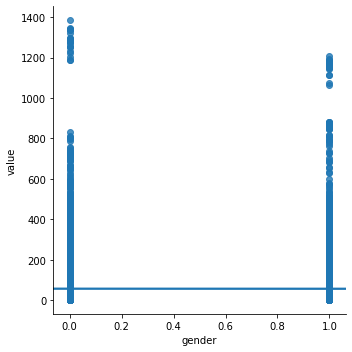

In [21]:
sns.lmplot(x='gender', y='value', data=df1)

In [22]:
df1['value'].isnull().sum()

0

In [23]:
target = 'value'
y = df1[target]
X = df1.drop(target, axis = 1)

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13200 entries, 1043 to 18407
Data columns (total 4 columns):
fulltime_parttime    13200 non-null object
occupation           13200 non-null object
gender               13200 non-null int64
age_group            13200 non-null object
dtypes: int64(1), object(3)
memory usage: 515.6+ KB


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [ ]:
y_train

In [ ]:
y_train

In [26]:
le = preprocessing.LabelEncoder()

le.fit(X_train['occupation'])
le.fit(X_test['occupation'])

le.fit(X_train['fulltime_parttime'])
le.fit(X_test['fulltime_parttime'])

le.fit(X_train['age_group'])
le.fit(X_test['age_group'])

le.fit(X_train['gender'])
le.fit(X_test['gender'])


LabelEncoder()

In [27]:
mapper = DataFrameMapper([
    (['occupation'], [LabelBinarizer()]),
    (['gender'], [LabelBinarizer()]),
    (['fulltime_parttime'], [LabelBinarizer()]),
    (['age_group'], [LabelBinarizer()])
    ], df_out= True)

In [ ]:
mapper

In [28]:
Z_train= mapper.fit(X_train)


In [29]:
Z_train= mapper.transform(X_train)

In [ ]:
Z_train

In [30]:
Z_test = mapper.transform(X_test)

In [ ]:
Z_test

In [31]:
model = LinearRegression(normalize=False)



In [32]:
model.fit(Z_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
y_pred = model.predict(Z_test)

In [ ]:
y_pred

In [34]:
from sklearn.metrics import mean_squared_error, r2_score

def rmse_score(model, Z_train, Z_test, y_train, y_test):
    mse_train = mean_squared_error(y_true = y_train,
                                  y_pred = model.predict(Z_train))
    mse_test = mean_squared_error(y_true = y_test,
                                  y_pred = model.predict(Z_test))
    rmse_train = mse_train ** 0.5/100
    rmse_test = mse_test ** 0.5/100
    
    print("The training RMSE for " + str(model) + " is: " + str(rmse_train))
    print("The testing RMSE for " + str(model) + "\ is: " + str(rmse_test))
    return (rmse_train, rmse_test)



In [35]:
rmse_score(model, Z_train, Z_test, y_train, y_test)

The training RMSE for LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) is: 0.9292061065269871
The testing RMSE for LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)\ is: 0.9416314117564343


(0.9292061065269871, 0.9416314117564343)

In [ ]:
y_test

In [ ]:
y_pred

In [36]:
r2_score(y_test, y_pred)

0.2918472587198804

In [ ]:
Z_test.shape

In [ ]:
y_test.size

In [ ]:
y_pred.size

In [37]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(Z_train, y_train)

rmse_score(knn_reg, Z_train, Z_test, y_train, y_test)


The training RMSE for KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform') is: 0.17781672850890032
The testing RMSE for KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')\ is: 0.20277153650769975


(0.17781672850890032, 0.20277153650769975)

In [38]:
cart_reg = DecisionTreeRegressor()
cart_reg.fit(Z_train, y_train)

rmse_score(cart_reg, Z_train, Z_test, y_train, y_test)


The training RMSE for DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best') is: 0.16794125174620345
The testing RMSE for DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')\ is: 0.19066790152831378


(0.16794125174620345, 0.19066790152831378)

In [39]:
bagged_reg = BaggingRegressor()
bagged_reg.fit(Z_train, y_train)

rmse_score(bagged_reg, Z_train, Z_test, y_train, y_test)





The training RMSE for BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False) is: 0.16857567498213247
The testing RMSE for BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)\ is: 0.19194192258604925


(0.16857567498213247, 0.19194192258604925)

In [40]:
adaboost_reg = AdaBoostRegressor()
adaboost_reg.fit(Z_train, y_train)

rmse_score(adaboost_reg, Z_train, Z_test, y_train, y_test)

The training RMSE for AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None) is: 1.2132515625002391
The testing RMSE for AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)\ is: 1.261074058594591


(1.2132515625002391, 1.261074058594591)

In [41]:
support_vector_reg = SVR()
support_vector_reg.fit(Z_train, y_train)

rmse_score(support_vector_reg, Z_train, Z_test, y_train, y_test)

The training RMSE for SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) is: 1.0278906851732623
The testing RMSE for SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)\ is: 1.0226318975536728


(1.0278906851732623, 1.0226318975536728)

In [42]:
pipe = Pipeline([("mapper", mapper), ("model", model)])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('mapper',
                 DataFrameMapper(default=False, df_out=True,
                                 features=[(['occupation'],
                                            [LabelBinarizer(neg_label=0,
                                                            pos_label=1,
                                                            sparse_output=False)]),
                                           (['gender'],
                                            [LabelBinarizer(neg_label=0,
                                                            pos_label=1,
                                                            sparse_output=False)]),
                                           (['fulltime_parttime'],
                                            [LabelBinarizer(neg_label=0,
                                                            pos_label=1,
                                                            sparse_output=False)]),
                 

In [43]:
employed_value = pipe.predict(X_test)

In [44]:
employed_value = (np.round(employed_value, 1)).astype('int')

In [45]:
employed_value

array([ 98,  27,  24, ..., -19, -21,  62])

In [46]:
pickle.dump(pipe, open('pipe.pkl', 'wb'))
del pipe
pipe = pickle.load(open('pipe.pkl', 'rb'))
pipe

Pipeline(memory=None,
         steps=[('mapper',
                 DataFrameMapper(default=False, df_out=True,
                                 features=[(['occupation'],
                                            TransformerPipeline(steps=[('labelbinarizer',
                                                                        LabelBinarizer(neg_label=0,
                                                                                       pos_label=1,
                                                                                       sparse_output=False))]),
                                            {}),
                                           (['gender'],
                                            TransformerPipeline(steps=[('labelbinarizer',
                                                                        LabelBinarizer(neg_label=0,
                                                                                       pos_label=1,
                                 